# Correlation matrices building for covariance localization

## Description

This notebook demonstrates how to build the correlation matrices ($\rho_{MD}$) and ($\rho_{DD}$) that are used to localize the covariance matrices by element-wise
multiplication (Schur product or Hadamard product) of the original covariance matrices:

$\tilde{C}^{l}_{MD} = \rho_{MD} \odot C^{l}_{MD}$

$\tilde{C}^{l}_{DD} = \rho_{DD} \odot C^{l}_{DD}$

with $\odot$ the element wise multiplication.

Once built these matrices can be passed to the constructor of an `ESMDA` instance using the keywords `md_correlation_matrix` and `dd_correlation_matrix` respectively.


## Motivation

The computational cost of `ESMDA` and other ensemble smoothers mainly depends on the ensemble size since the computation of the prediction vectors `d_pred` requires $N_{e}$ simulations at each assimilation. Consequently, the number of ensemble realizations should be kept as small as possible to reduce computational burden.
However, when the size of the ensemble chosen for inversion is too small, it might not be statistically representative of the variability of the unknowns: The low rank approximation of the error covariance matrix introduces sampling errors which decrease proportionally to $1/\sqrt(N_{e})$ [1]. For small $N_{e}$, long-range spurious correlations might appear causing the filter divergence. Covariance localization (CL) is a technique developed to overcome these issues.

The method relies on element-wise multiplication of the original covariance matrices by space and (optionally) time dependent correlation function that reduces the correlations between space and time distant observations and parameters.

Note that the space and time correlation matrices are computed independently and are gathered afterwards by element-wise multiplication.

## References

[1] G. Evensen. The Ensemble Kalman Filter: Theoretical formulation and practical implementation. Ocean Dynamics, 53(4):343–367, 2003. ISSN 16167341. doi: 10.1007/s10236-003-0036-9.

[2] Todaro, V. (2021). Advanced techniques for solving groundwater and surface water problems in the context of inverse methods and climate change [Tesis doctoral]. Universitat Politècnica de València. https://doi.org/10.4995/Thesis/10251/166439

- Import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import numpy as np
import numpy.typing as npt
from pyesmda import distances_to_weights_fifth_order, distances_to_weights_beta_cumulative

- Type hints for numpy

In [2]:
NDArrayFloat = npt.NDArray[np.float64]

- Define some configurations for the plots

In [3]:
# Some configurations for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.rcParams.update(new_rc_params)

## Correlation functions

For both time and space correlation matrices, we need to functions that transform distances into weights in the interval [0-1]. Intuitively, the weight should decrease when the distance increases. Probability density functions are quite interesting to achieve that. 
- An example is a reversed beta cumulative distribution function.

$1 - \dfrac{1}{1 + \left(\dfrac{d}{1 - d}\right)^{-\beta}}$ 

with $d$ the distance, and $\beta$ the shape parameter.

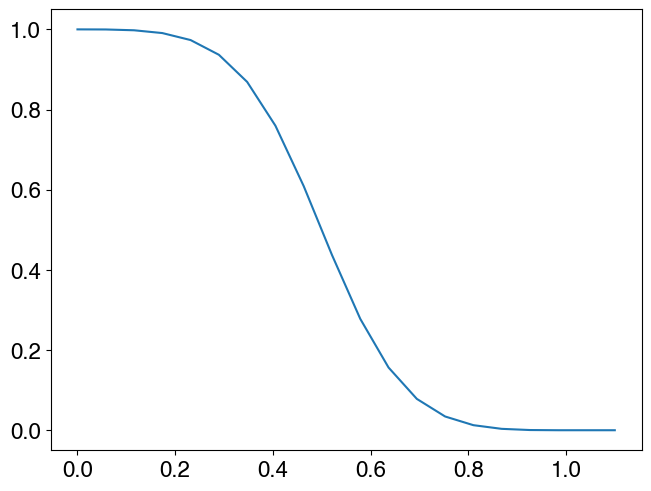

In [4]:
x = np.linspace(0, 1.1, 20)
plt.plot(x, distances_to_weights_beta_cumulative(x, beta=3))

- When plotting the function, it can be seen that after 1.0, the function is always 0.0. To overcome this issue, we apply a scaling factor by wrapping it in a distance_to_weight function

$1 - \dfrac{1}{1 + \left(\dfrac{d}{s - d}\right)^{-\beta}}$ 

with $d$ the distance, $s$ is the scaling factor and $\beta$ the shape parameter.

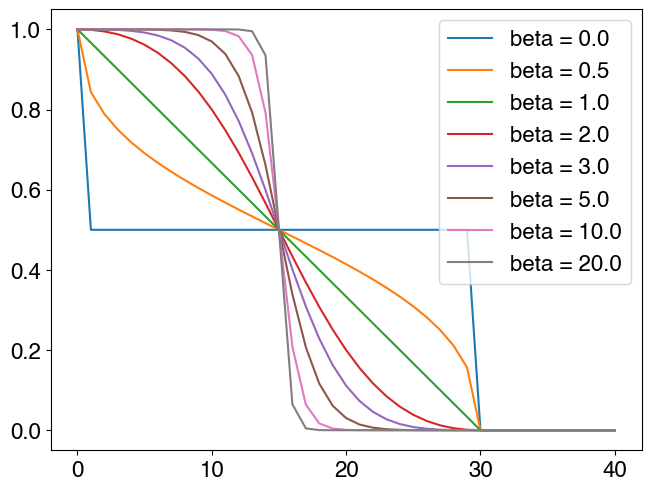

In [5]:
x = np.linspace(0, 40, 41)
scaling_factor = 30  # meters
for beta in [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]:
    plt.plot(x, distances_to_weights_beta_cumulative(x, scaling_factor=scaling_factor, beta=beta), label=f"beta = {beta}")
plt.legend()

Note: many other function could be used. In her PdD manuscript, Todaro (2021) implement a fifth order correlation function proposed by Gaspari & Cohn (1999) which acts very similarly but without beta parameter.

See: Gaspari, G. & Cohn, S. E. (1999), ‘Construction of correlation functions in two 
and three dimensions’, Quarterly Journal of the Royal 
Meteorological Society 125(554), 723–757

$$
f(z) =
    \begin{cases}
    0 & z < 0 \\
      \dfrac{-1}{4} z^{5} + \dfrac{1}{2} z^{4} + \dfrac{5}{8} z^{3} - \dfrac{5}{3} z^{2} + 1 & 0 \leq z \leq 1\\
      \dfrac{1}{12} z^{5} - \dfrac{1}{2} z^{4} + \dfrac{5}{8} z^{3} + \dfrac{5}{3} z^{2} - 5z + 4 - \dfrac{2}{3} z^{-1} & 1 \leq z \leq 2\\
    \end{cases} 
$$

with $z = \dfrac{d}{s}$ 

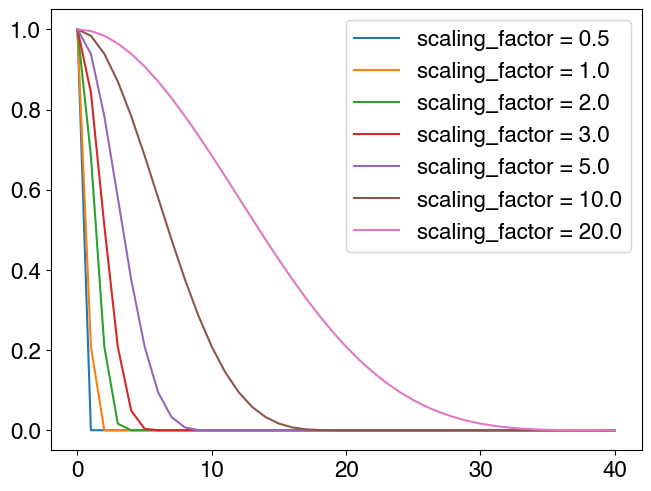

In [6]:
for scaling_factor in [0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]:
    plt.plot(x, distances_to_weights_fifth_order(x, scaling_factor), label=f"scaling_factor = {scaling_factor}")
plt.legend()

## General procedure

No matter the matrix being built, a straightforward approach is:
1) Create vectors of coordinates (time or space)
2) Compute the distance matrix between two vectors of coordinates obtained in 1) (param-obs or obs-obs)
3) Apply a distance_to_weight function to the matrix from 2)

## Parameters - observations correlation matrix

### Spatial correlation matrix

The goal is to build the covariance matrix between the adjusted parameters and the observations.

For simplicity, let's consider:
- A regular (4, 5) grid with non square meshes = different dx & dy.
- A single parameter adjusted over the all grid, 
- 3 observation locations with 10, 9 and 15 observation values for the three locations respectively. 

The correlation matrix is expected to have the dimensions ($N_{m}$, $N_{obs}$) with $N_{m}$ the number of adjusted parameter values = the number of gridcells, and $N_{obs}$ the number of observations (10 + 9 + 15 = 34).

- Define and plot the grid


(20, 2)


Text(0, 0.5, 'Y (m)')

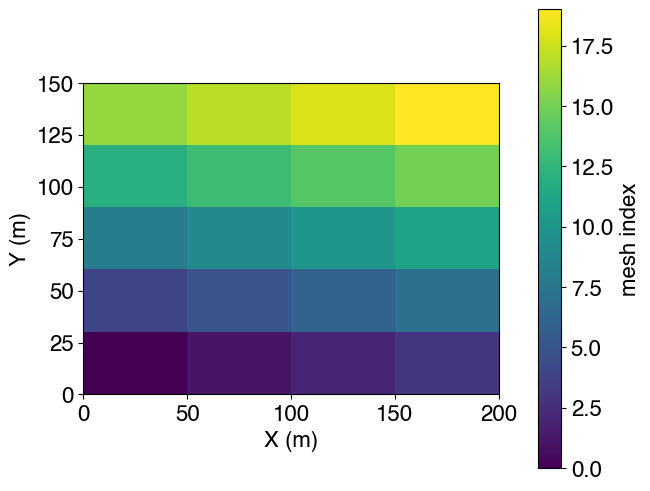

In [7]:
# grid dimensions
nx = 4
dx = 50
ny = 5
dy = 30

# Vectors of x and y coordinates (case of a regular grid)
x_vect_coords = np.linspace(0, (nx - 1) * dx, nx)
y_vect_coords = np.linspace(0, (ny - 1) * dy, ny)

# Build grid coordinates from it -> 2D array with dimensions (nx * ny, 2)
coordinates = np.array(np.meshgrid(x_vect_coords, y_vect_coords), order="F").reshape(2, -1).T

# 20 cells expected
print(coordinates.shape)

# mesh indices
mesh_indices = np.arange(nx * ny).reshape(ny, nx)

# Show the mesh indices
plt.imshow(mesh_indices, origin="lower", extent=(0.0, nx * dx, 0.0, ny * dy))
plt.colorbar(label="mesh index")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

In [8]:
from typing import Tuple

def node_number_to_indices(
    node_number: int,
    nx: int = 1,
    ny: int = 1,
    indices_start_at_one: bool = False,
) -> Tuple[int, int, int]:
    """
    Convert an node-number to indices (ix, iy, iz).

    For 1D and 2D, simply leave ny, and nz to their default values.

    Note
    ----
    Node numbering start at zero.

    Warning
    -------
    This applies only for regular grids. It is not suited for vertex.

    Parameters
    ----------
    nx : int, optional
        Number of meshes on the x-axis. The default is 1.
    ny : int, optional
        Number of meshes on the y-axis. The default is 1.
    indices_start_at_one: bool, optional
        Whether the indices start at 1. Otherwise, start at 0. The default is False.

    Returns
    -------
    Tuple[int, int, int]
        The grid indices.

    """
    ix = (node_number) % nx
    iz = (node_number - ix) // (nx * ny)
    iy = (node_number - ix - (nx * ny) * iz) // nx

    if indices_start_at_one:
        ix += 1
        iy += 1
        iz += 1

    return ix, iy, iz

In [9]:
node_number_to_indices(np.arange(nx * ny), nx=nx, ny=ny)

(array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [10]:
coordinates

array([[  0.,   0.],
       [ 50.,   0.],
       [100.,   0.],
       [150.,   0.],
       [  0.,  30.],
       [ 50.,  30.],
       [100.,  30.],
       [150.,  30.],
       [  0.,  60.],
       [ 50.,  60.],
       [100.,  60.],
       [150.,  60.],
       [  0.,  90.],
       [ 50.,  90.],
       [100.,  90.],
       [150.,  90.],
       [  0., 120.],
       [ 50., 120.],
       [100., 120.],
       [150., 120.]])

- Define and plot the observation locations

Text(0, 0.5, 'Y (m)')

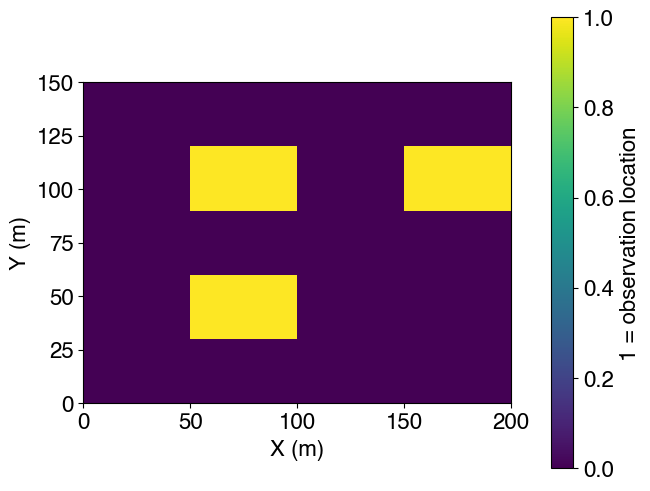

In [11]:
# number of values per observartion locations
n_obs_list = [10, 9, 15]

obs_grid_indices = [(1, 1), (3, 3), (1, 3)]
obs_grid_positions = [(i * dx, j * dy) for i, j in obs_grid_indices]

grid_obs = np.zeros((ny, nx))

for x_index, y_index in obs_grid_indices:
    grid_obs[y_index, x_index] = 1.0

# plot the observation locations in the grid
plt.imshow(grid_obs, origin="lower", extent=(0.0, nx * dx, 0.0, ny * dy))
plt.colorbar(label="1 = observation location")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

- The vector of parameter coordinates is already built. Let's do the same for the observations

In [12]:
# one coordinates set per obs value
obs_val_coords = np.concatenate(
    [[obs_grid_positions[i]] * n_obs_list[i] for i in range(len(obs_grid_positions))],
    axis=0,
)

- The distance and weight matrices can be directly computed from these two vectors

md_space_correlation_matrix.shape = (20, 34)


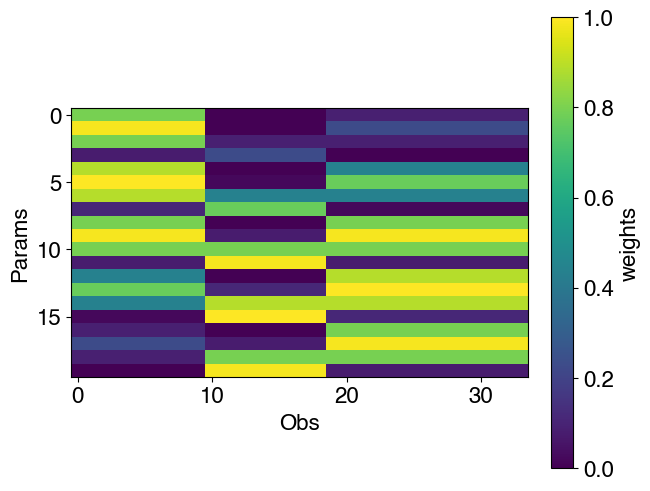

In [13]:
# distance matrix computation
md_space_distances_mat = distance_matrix(coordinates, obs_val_coords)
# weight distance computation
md_space_correlation_matrix = distances_to_weights_beta_cumulative(
    md_space_distances_mat, beta=3, scaling_factor=150
)

print(f"md_space_correlation_matrix.shape = {md_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(md_space_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Params")
plt.colorbar(label="weights")

### Time correlation matrix

If both adjusted parameters and observations depend on time, it might be interesting to add time correlations (not alwayd relevant). The procedure is the same than for the spatial correlation but with time coordinates. For the simplicity of the example, it is assumed that the time of acquisition of the observation is equal to two indices in the value table, and that all parameters are at time 0.0.

In [14]:
# one time per obs value. Note that we need to insert a column filled with zeros (2d array expected).
obs_val_times = np.zeros((sum(n_obs_list), 2))
obs_val_times[:, 0] = np.concatenate(
    [range(n_obs_list[i]) for i in range(len(n_obs_list))]
)

In [15]:
param_vals_times = np.zeros((nx * ny, 2))

md_time_correlation_matrix.shape = (20, 34)


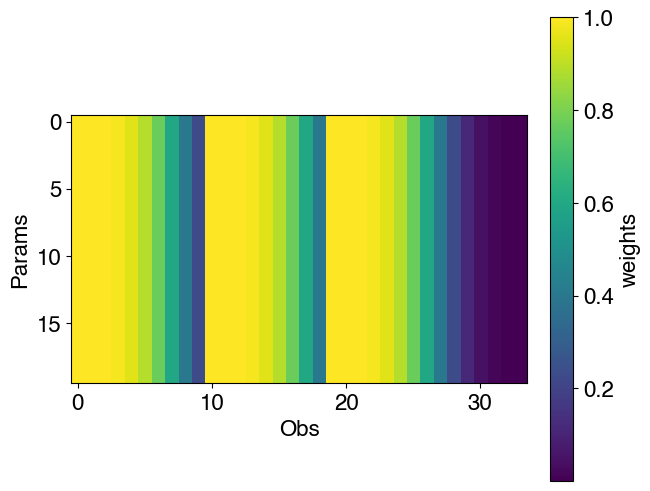

In [16]:
# distance matrix computation
md_time_distances_mat = distance_matrix(param_vals_times, obs_val_times)
# weight distance computation
md_time_correlation_matrix = distances_to_weights_beta_cumulative(
    md_time_distances_mat, beta=3, scaling_factor=15
)

print(f"md_time_correlation_matrix.shape = {md_time_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(md_time_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Params")
plt.colorbar(label="weights")

### Merging space and time correlation matrices

Simply apply and element-wise multiplication

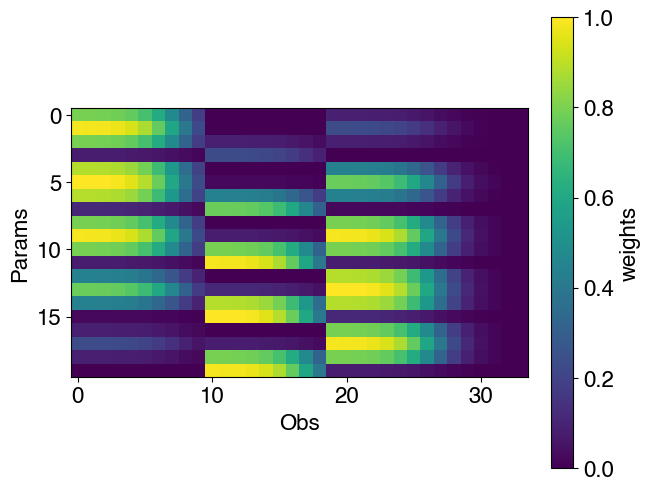

In [17]:
md_correlation_matrix = md_space_correlation_matrix * md_time_correlation_matrix

# Plot the correlation matrix
plt.imshow(md_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Params")
plt.colorbar(label="weights")

## Observations - observations correlation matrix

### Spatial correlation matrix

As for the parameter-observable covariance matrix, we use the distance between the observation locations to build the matrix.

dd_space_correlation_matrix.shape = (34, 34)


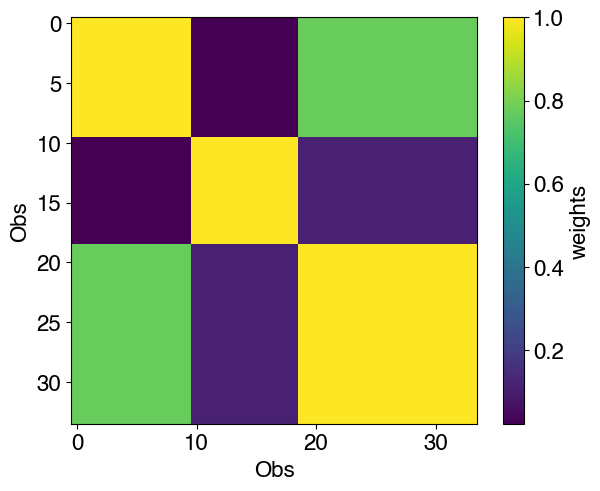

In [18]:
# distance matrix computation
obs_distances_mat = distance_matrix(obs_val_coords, obs_val_coords)
# weight distance computation
dd_space_correlation_matrix = distances_to_weights_beta_cumulative(
    obs_distances_mat, beta=3, scaling_factor=150
)

print(f"dd_space_correlation_matrix.shape = {dd_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(dd_space_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Obs")
plt.colorbar(label="weights")

### Time correlation matrix

One possibility is also to decorrelate the observations having been made at distant times. The procedure to build the matrix is very similar to the one used to build the spatial covariance matrix. The only difference is that temporal coordinates are used and not spatial coordinates.

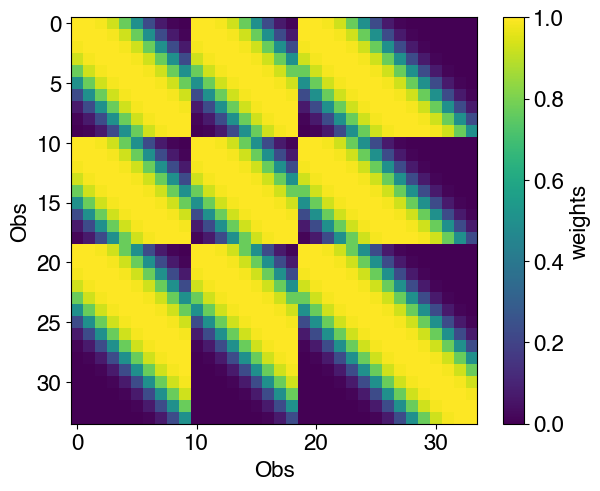

In [19]:
# one time per obs value. Note that we need to insert a zero column.
obs_val_times = np.zeros((sum(n_obs_list), 2))
obs_val_times[:, 0] = np.concatenate(
    [range(n_obs_list[i]) for i in range(len(n_obs_list))]
)
# time-distance matrix computation
obs_time_distances_mat = distance_matrix(obs_val_times, obs_val_times)
# weight distance computation
dd_time_correlation_matrix = distances_to_weights_beta_cumulative(
    obs_time_distances_mat, beta=3, scaling_factor=10
)

# Plot the correlation matrix
plt.imshow(dd_time_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Obs")
plt.colorbar(label="weights")

### Merging space and time localization matrices

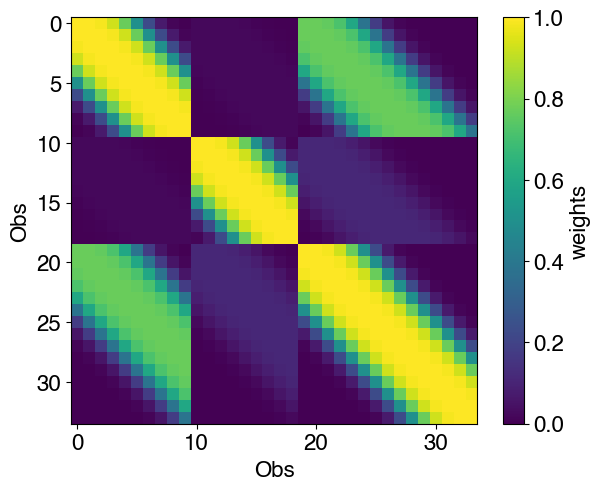

In [20]:
dd_correlation_matrix = dd_space_correlation_matrix * dd_time_correlation_matrix

# Plot the correlation matrix
plt.imshow(dd_correlation_matrix)
plt.xlabel("Obs")
plt.ylabel("Obs")
plt.colorbar(label="weights")